### Desafio 3
Modelo many to many usando Moby dick como corpus.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos


In [2]:
from nltk.corpus import gutenberg
import nltk
nltk.download('gutenberg')
import nltk
nltk.download('punkt')
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
moby_dick = gutenberg.sents('melville-moby_dick.txt')

In [4]:
len(moby_dick)

10059

In [5]:
# Convierto cada sublista (oración) en una cadena de texto
sents_text = [' '.join(sentence) for sentence in moby_dick]

df = pd.DataFrame(sents_text, columns=['Lines'])
df.head()

,Lines
0,[ Moby Dick by Herman Melville 1851 ]
1,ETYMOLOGY .
2,( Supplied by a Late Consumptive Usher to a Gr...
3,"The pale Usher -- threadbare in coat , heart ,..."
4,He was ever dusting his old lexicons and gramm...


In [6]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 10059


### Elegir el tamaño del contexto

In [7]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [8]:
# cada verso lo guardamos en una lista
text = list(df.iloc[:,0])
text

['[ Moby Dick by Herman Melville 1851 ]',
 'ETYMOLOGY .',
 '( Supplied by a Late Consumptive Usher to a Grammar School )',
 'The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now .',
 'He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world .',
 'He loved to dust his old grammars ; it somehow mildly reminded him of his mortality .',
 '" While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ."',
 '-- HACKLUYT',
 '" WHALE .',
 '... Sw . and Dan .',
 'HVAL .',
 'This animal is named from roundness or rolling ; for in Dan .',
 'HVALT is arched or vaulted ."',
 "-- WEBSTER ' S DICTIONARY",
 '" WHALE .',
 '...',
 'It is more immediately from the Dut .',
 'and

In [9]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [10]:
text[0]

'[ Moby Dick by Herman Melville 1851 ]'

In [11]:
segmented_sentences[0]

['moby', 'dick', 'by', 'herman', 'melville', '1851']

In [12]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([6.375e+03, 2.635e+03, 7.710e+02, 1.890e+02, 5.200e+01, 2.000e+01,
        9.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0.  ,  23.75,  47.5 ,  71.25,  95.  , 118.75, 142.5 , 166.25,
        190.  , 213.75, 237.5 , 261.25, 285.  , 308.75, 332.5 , 356.25,
        380.  , 403.75, 427.5 , 451.25, 475.  ]),
 <BarContainer object of 20 artists>)

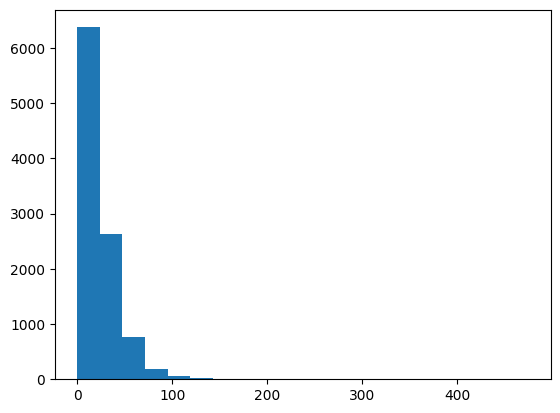

In [13]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

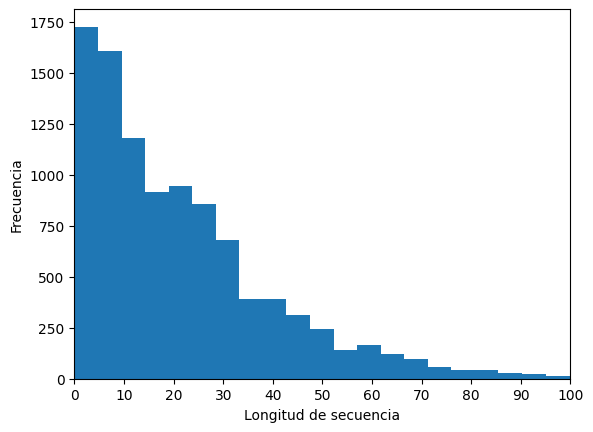

In [14]:
plt.hist(length_sentences, bins=100)
plt.xlabel('Longitud de secuencia')
plt.ylabel('Frecuencia')
plt.xlim(0, 100)
plt.xticks(range(0, 101, 10))

plt.show()

In [15]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 47


In [16]:
#Decido elegir un valor cercano al p75
max_context_size = 30

In [17]:
print(len(segmented_sentences))
segmented_sentences = [sentence for sentence in segmented_sentences if len(sentence) > 0]

print(len(segmented_sentences))

10059
10033


###  Tokenizar

In [18]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [19]:
tokenized_sentences[0]

[281, 282, 24, 9602, 9603, 5109]

In [20]:
segmented_sentences[0]

['moby', 'dick', 'by', 'herman', 'melville', '1851']

### Organizando y estructurando el dataset

In [21]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Split de las oraciones que tienen tamaño mayor al contexto máximo, para generar más secuencias de entrenamiento.

In [22]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [23]:
len(tok_sent)

47400

 Aumento de los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

In [24]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+10] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [25]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [26]:
train_seqs.shape

(1312943, 31)

In [27]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [28]:
y.shape

(1312943, 30)

In [29]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'of',
 3: 'and',
 4: 'a',
 5: 'to',
 6: 'in',
 7: 'that',
 8: "'",
 9: 'his',
 10: 'it',
 11: 'i',
 12: 'he',
 13: 'but',
 14: 's',
 15: 'as',
 16: 'is',
 17: 'with',
 18: 'was',
 19: 'for',
 20: 'all',
 21: 'this',
 22: 'at',
 23: 'whale',
 24: 'by',
 25: 'not',
 26: 'from',
 27: 'him',
 28: 'so',
 29: 'on',
 30: 'be',
 31: 'one',
 32: 'you',
 33: 'there',
 34: 'now',
 35: 'had',
 36: 'have',
 37: 'or',
 38: 'were',
 39: 'they',
 40: 'which',
 41: 'like',
 42: 'me',
 43: 'then',
 44: 'their',
 45: 'what',
 46: 'some',
 47: 'when',
 48: 'are',
 49: 'an',
 50: 'my',
 51: 'no',
 52: 'upon',
 53: 'out',
 54: 'man',
 55: 'into',
 56: 'up',
 57: 'ship',
 58: 'ahab',
 59: 'more',
 60: 'if',
 61: 'them',
 62: 'ye',
 63: 'we',
 64: 'sea',
 65: 'old',
 66: 'would',
 67: 'other',
 68: 'been',
 69: 'over',
 70: 'these',
 71: 'will',
 72: 'though',
 73: 'down',
 74: 'its',
 75: 'only',
 76: 'such',
 77: 'who',
 78: 'head',
 79: 'yet',
 80: 'boat',
 81: 'time',
 82: 'long',
 83: 'her

In [30]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

17140

In [31]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'of': 2, 'and': 3, 'a': 4, 'to': 5, 'in': 6, 'that': 7, "'": 8, 'his': 9, 'it': 10, 'i': 11, 'he': 12, 'but': 13, 's': 14, 'as': 15, 'is': 16, 'with': 17, 'was': 18, 'for': 19, 'all': 20, 'this': 21, 'at': 22, 'whale': 23, 'by': 24, 'not': 25, 'from': 26, 'him': 27, 'so': 28, 'on': 29, 'be': 30, 'one': 31, 'you': 32, 'there': 33, 'now': 34, 'had': 35, 'have': 36, 'or': 37, 'were': 38, 'they': 39, 'which': 40, 'like': 41, 'me': 42, 'then': 43, 'their': 44, 'what': 45, 'some': 46, 'when': 47, 'are': 48, 'an': 49, 'my': 50, 'no': 51, 'upon': 52, 'out': 53, 'man': 54, 'into': 55, 'up': 56, 'ship': 57, 'ahab': 58, 'more': 59, 'if': 60, 'them': 61, 'ye': 62, 'we': 63, 'sea': 64, 'old': 65, 'would': 66, 'other': 67, 'been': 68, 'over': 69, 'these': 70, 'will': 71, 'though': 72, 'down': 73, 'its': 74, 'only': 75, 'such': 76, 'who': 77, 'head': 78, 'yet': 79, 'boat': 80, 'time': 81, 'long': 82, 'her': 83, 'captain': 84, 'any': 85, 'here': 86, 'very': 87, 'still': 88, 'about': 89, 'th

In [32]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'moby': 79, 'dick': 79, 'by': 1032, '1851': 3, 'melville': 1, 'herman': 1, 'etymology': 1, 'school': 9, 'to': 3189, 'late': 30, 'consumptive': 1, 'supplied': 12, 'a': 3155, 'usher': 2, 'grammar': 2, 'and': 3888, 'brain': 34, 'i': 1605, 'now': 753, 'the': 5750, 'see': 263, 'him': 877, 'threadbare': 1, 'coat': 26, 'heart': 89, 'body': 108, 'pale': 18, 'in': 2988, 'queer': 33, 'all': 1335, 'world': 173, 'dusting': 2, 'handkerchief': 5, 'of': 3784, 'his': 1729, 'mockingly': 1, 'with': 1464, 'known': 78, 'nations': 12, 'embellished': 3, 'grammars': 2, 'old': 412, 'lexicons': 1, 'gay': 21, 'he': 1474, 'ever': 196, 'flags': 1, 'was': 1338, 'loved': 3, 'somehow': 44, 'reminded': 4, 'it': 2009, 'mortality': 1, 'dust': 10, 'mildly': 10, 'take': 131, 'alone': 40, 'leaving': 37, 'them': 427, 'signification': 1, 'you': 670, 'while': 231, 'whale': 1086, 'hand': 201, 'which': 593, 'name': 68, 'others': 39, 'our': 176, 'almost': 189, 'be': 905, 'h': 3, 'fish': 153, 'out': 5


### Definir el modelo

In [33]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=20, input_shape=(max_context_size,)))

model.add((LSTM(64*2, return_sequences=True)))
model.add(Dropout(0.3))
model.add((LSTM(64, return_sequences=True)))

model.add(Dense(vocab_size+1, activation='softmax'))


#optimizador = Adam(learning_rate=0.001)
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 30, 20)              │         342,820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 30, 128)             │          76,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30, 17141)           │       1,114,165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,582,681 (6.04 MB)

 Trainable params: 1,582,681 (6.04 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [35]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=10000)

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node sequential_1/dense_1/MatMul defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-35-58439ea79ef3>", line 5, in <cell line: 5>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 212, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 144, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 3445, in matmul

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 483, in matmul

OOM when allocating tensor with shape[10000,30,17141] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/dense_1/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_2726]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción de próxima palabra

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

### Generación de secuencias

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [ ]:

input_text='On the second day\'t'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens


In [ ]:
# predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="On the second day",temp=1,mode='sto')

In [ ]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

In [ ]:
# veamos las salidas
decode(salidas[0])

In [ ]:
# predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="On the second day",temp=1,mode='det')

In [ ]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

In [ ]:
# veamos las salidas
decode(salidas[0])